<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/projetos/gecco_water_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [43]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm, trange

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data Loading

In [45]:
training_data = pd.read_csv(
    'https://www.dropbox.com/s/z32q8nks8iqkiuv/waterDataTraining.csv?dl=1',
    index_col=0)
testing_data = pd.read_csv(
    'https://www.dropbox.com/s/3ptrkyisyks2us3/waterDataTesting.csv?dl=1',
    index_col=0)

In [106]:
val_idx = round(training_data.shape[0]/2)
train_data = training_data[:val_idx]
val_data = training_data[val_idx:]

# Exploratory Data Analysis

In [8]:
# Perform any EDA here

# Data Processing

In [74]:
window_trend = 24 * 60 # 1 day (24 hours x 60 minutes)

def preprocess_data(data, means=None, stds=None):
    X = data.iloc[:,1:-1]
    missing_data = 1.0 * (X.isna().sum(axis=1) > 0)
    X = X.bfill()
    y = data['EVENT']
    X_trend = X.rolling(window_trend, min_periods=1).mean()
    X -= X_trend
    if means is None:
        means = X.mean()
    if stds is None:
        stds = X.std()
    X_detrended = (X - means)/stds
    X_detrended['missing'] = missing_data
    X['missing'] = missing_data
    return torch.tensor(X_detrended.values).to(device), torch.tensor(X.values).to(device), torch.tensor(y.values, dtype=torch.double).to(device), means, stds

In [108]:
X_train, X_train_orig, y_train, means, stds = preprocess_data(train_data)
X_val, X_val_orig, y_val, _, _ = preprocess_data(val_data, means=means, stds=stds)
X_test, X_test_orig, y_test, _, _ = preprocess_data(testing_data, means=means, stds=stds)

# Modeling

## Pytorch Dataset and Dataloader

In [109]:
class TimeseriesDataset(Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len].T, self.y[index+self.seq_len-1])

In [110]:
window = 30

In [111]:
weights = torch.FloatTensor([1, 1/y_train.mean()]).to(device)
samples_weight = torch.Tensor([weights[int(t)] for t in y_train[window-1:]])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [112]:
batch_size = 128

train_dataset = TimeseriesDataset(X_train, y_train, seq_len=window)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

train_val_dataset = TimeseriesDataset(X_train, y_train, seq_len=window)
train_val_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TimeseriesDataset(X_val, y_val, seq_len=window)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TimeseriesDataset(X_test, y_test, seq_len=window)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## ANN Models

In [113]:
class DeepNet(torch.nn.Module):

  def __init__(self, window=30, n_hidden_layers=6, hidden_layer_dim=128,
               kernel_size=3, use_batch_norm=True):

    super(DeepNet, self).__init__()

    self.convs = [torch.nn.Conv1d(10, hidden_layer_dim, kernel_size)]
    for _ in range(n_hidden_layers):
      self.convs.append(
          torch.nn.Conv1d(hidden_layer_dim, hidden_layer_dim, kernel_size)
      )
    self.convs = torch.nn.ModuleList(self.convs)

    self.batch_norms = torch.nn.ModuleList([
        torch.nn.BatchNorm1d(hidden_layer_dim)
        if use_batch_norm else None
        for _ in range(n_hidden_layers + 1)
    ])

    pool_size = window - len(self.convs)*(kernel_size - 1)
    self.pool = torch.nn.AvgPool1d(pool_size)

    self.fc1 = torch.nn.Linear(hidden_layer_dim, hidden_layer_dim)
    self.fc2 = torch.nn.Linear(hidden_layer_dim, 1)

  def forward(self, x):

    for conv, bn in zip(self.convs, self.batch_norms):
      x = conv(x)
      if bn is not None:
        x = bn(x)
      x = torch.relu(x)

    x = self.pool(x)
    x = torch.flatten(x, 1)

    x = self.fc1(x)
    feat = torch.relu(x)

    x = self.fc2(feat)

    return x, feat

# Training and evaluation functions

In [114]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loader):
        input, label = data
        optimizer.zero_grad()
        output, _ = model(input)
        loss = criterion(output.flatten(), label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, labels = data
            outputs, _ = model(inputs)
            loss = criterion(outputs.flatten(), labels)
            running_loss += loss.item()
    return running_loss / len(loader)

In [ ]:
model = DeepNet(window).double().to(device)

train_criterion = torch.nn.BCEWithLogitsLoss()
val_criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

epochs = 1
train_epoch_loss = []
val_epoch_loss = []
for epoch in tqdm(range(epochs)):
    train_loss = train(model, train_loader, train_criterion, optimizer)
    val_loss = validate(model, val_loader, val_criterion)
    train_epoch_loss.append(train_loss)
    val_epoch_loss.append(val_loss)

plt.plot(train_epoch_loss)
plt.plot(val_epoch_loss)
plt.xlabel('epoch')
plt.ylabel('BCELoss')
plt.show()

# Model Evaluation

In [116]:
def compute_outputs_and_features(model, data_loader):
    model.eval()
    all_outputs = []
    all_features = []
    for i, data in enumerate(data_loader):
        inputs, _ = data
        with torch.no_grad():
            outputs, features = model(inputs)
            outputs = torch.sigmoid(outputs)
        all_outputs.append(outputs.flatten())
        all_features.append(features)
    y_pred = torch.cat(all_outputs).cpu().numpy()
    feat = torch.cat(all_features).cpu().numpy()
    return y_pred, feat

In [117]:
y_train_pred, feat_train = compute_outputs_and_features(model, train_val_loader)
y_val_pred, feat_val = compute_outputs_and_features(model, val_loader)
y_test_pred, feat_test = compute_outputs_and_features(model, test_loader)

In [118]:
th = 0.5
print(metrics.classification_report(y_train[window-1:].cpu() > th, y_train_pred > th))

              precision    recall  f1-score   support

       False       1.00      0.93      0.96      4827
        True       0.29      1.00      0.45       144

    accuracy                           0.93      4971
   macro avg       0.64      0.96      0.70      4971
weighted avg       0.98      0.93      0.95      4971



In [119]:
th = 0.5
print(metrics.classification_report(y_val[window-1:].cpu() > th, y_val_pred > th))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98      4884
        True       0.21      0.51      0.30        87

    accuracy                           0.96      4971
   macro avg       0.60      0.74      0.64      4971
weighted avg       0.98      0.96      0.97      4971



In [ ]:
th = 0.05
print(metrics.classification_report(y_test[window-1:].cpu() > th, y_test_pred > th))

              precision    recall  f1-score   support

       False       1.00      0.70      0.83    137208
        True       0.05      0.91      0.09      2329

    accuracy                           0.71    139537
   macro avg       0.52      0.81      0.46    139537
weighted avg       0.98      0.71      0.81    139537



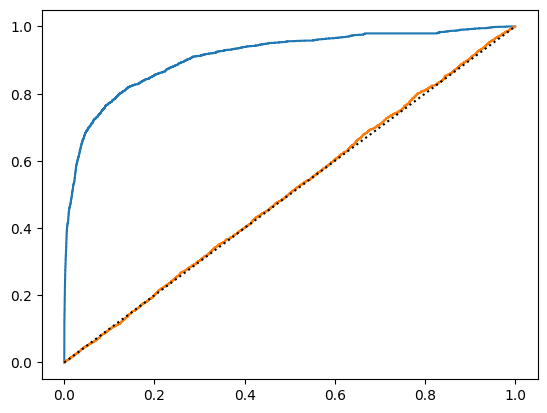

In [ ]:
fpr, tpr, th = metrics.roc_curve(y_test[window-1:].cpu(), y_test_pred)
plt.plot(fpr, tpr)

fpr, tpr, th = metrics.roc_curve(y_test[window-1:].cpu(), torch.rand(y_test_pred.shape))
plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], ':k')

plt.show()